# Calculating compartments
### test data
HFF_MicroC.mcool: https://files.osf.io/v1/resources/hjcxg/providers/osfstorage/5f73756d9e9a3d03ec6e3922?action=download&direct&version=1

In [1]:
import cooler
import pandas as pd
import cooltools

resolution = 100000
coolfile=f'/Users/yuanzan/Downloads/HFF_MicroC.mcool::resolutions/{resolution}'
clr=cooler.Cooler(coolfile)

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/Users/yuanzan/anaconda3/lib/python3.8/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_asymmetric(x, max_iter=1000, tol=1e-5, verb

In [2]:
clr.chromsizes

name
chr2     242193529
chr17     83257441
Name: length, dtype: int32

In [3]:
## fasta sequence is required for calculating binned profile of GC conent
import bioframe
bins = clr.bins()[:]
### Unified chromosome Naming
bins['chrom'] = bins['chrom'].str.lstrip('chr')

hg38_genome = bioframe.load_fasta('/Users/yuanzan/Documents/ref/GRCh38.105.fa');
## note the next command may require installing pysam
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], hg38_genome)
gc_cov['chrom'] = 'chr' + gc_cov['chrom'].astype(str)
gc_cov.to_csv('hg38_gc_cov_100kb.tsv',index=False,sep='\t')
display(gc_cov)

,chrom,start,end,GC
0,chr2,0,100000,0.435867
1,chr2,100000,200000,0.409530
2,chr2,200000,300000,0.421890
3,chr2,300000,400000,0.431870
4,chr2,400000,500000,0.458610
...,...,...,...,...
3250,chr17,82800000,82900000,0.528210
3251,chr17,82900000,83000000,0.518530
3252,chr17,83000000,83100000,0.561450
3253,chr17,83100000,83200000,0.535119


In [4]:
view_df = pd.DataFrame({'chrom': clr.chromnames,
                        'start': 0,
                        'end': clr.chromsizes.values,
                        'name': clr.chromnames}
                      )
display(view_df)

,chrom,start,end,name
0,chr2,0,242193529,chr2
1,chr17,0,83257441,chr17


In [5]:
# obtain first 3 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=view_df,
                        n_eigs=3,
                        )
# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
display(cis_eigs[0])
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]

/Users/yuanzan/anaconda3/lib/python3.8/site-packages/cooltools/lib/checks.py:550: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in track.groupby([track.columns[0]]):


,chrom,start,end,name,eigval1,eigval2,eigval3
0,chr2,0,242193529,chr2,1228.444578,455.255083,-413.285697
1,chr17,0,83257441,chr17,363.105343,187.531256,-151.825899


In [6]:
eigenvector_track.to_csv('eigenvector_track.bdg', sep="\t", index=False, header=False)

## visualization of insulation

In [7]:
import trackc as tc

no max min range
maxrange: 119.0 minrange: 1.0


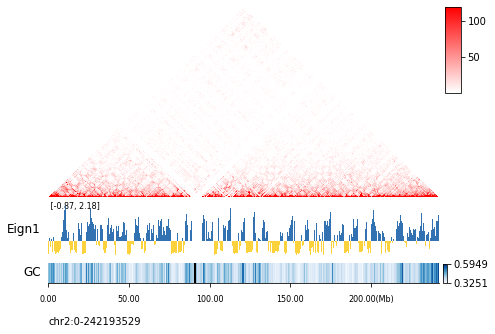

In [8]:
regions = "chr2:0-242193529"

HFF = tc.tl.extractCisContact(clr=coolfile, region=regions)

ten = tc.tenon(figsize=(7, 1))
ten.add(pos="bottom", height=3.5, hspace=0.05)
ten.add(pos="bottom", height=1, hspace=0.09)
ten.add(pos="bottom", height=0.4, hspace=0.09)


tc.pl.mapC(
    ax=ten.axs(0),
    mat=HFF,
    label="HFF",
    map_type="tri",
    ax_on=False
)

tc.pl.bed_track(
    ax=ten.axs(1),
    bed=eigenvector_track,
    regions=regions,
    style="bar",
    label="Eign1"
)


tc.pl.bed_track(
    ax=ten.axs(2),
    bed=gc_cov,
    regions=regions,
    style="rec",
    label="GC",
    cmap='Blues'
)


tc.pl.scale_track(ax=ten.axs(2), region=regions, scale_adjust="Mb", tick_pos="bottom", ratio2ax=2, space=0)
